In [1]:
a=1
a

1

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#读取arousal数据
arousal = pd.read_csv('arousal.csv',index_col=0)
data_arousal=[]
for i in range(0,744):
    X=np.array(arousal.iloc[i].dropna(axis=0,how='any'))
    data_arousal.append(X)

#读取valence数据
valence = pd.read_csv('valence.csv',index_col=0)
data_valence=[]
for i in range(0,744):
    X=np.array(valence.iloc[i].dropna(axis=0,how='any'))
    data_valence.append(X)

In [27]:
def makeXy(ts, nb_timesteps,stride):
    """
    Input: 
           ts: 时间序列数据
           nb_timesteps: 数据帧的长度
           stride：数据帧之间的步长
    Output: 
           x_dataset: 2-D array of regressors
           y_dataset: 1-D array of target 
    """
    x_dataset = []
    y_dataset = []
    for i in range(len(ts)):
        data=ts[i]
        for j in range(0,60-nb_timesteps,stride):
            x=data[j:j+nb_timesteps]
            y=data[j+nb_timesteps]
            x_dataset.append(x)
            y_dataset.append(y)
    x_dataset,y_dataset=np.array(x_dataset),np.array(y_dataset)
    return x_dataset, y_dataset

In [48]:
from sklearn.model_selection import train_test_split
nb_timesteps=10
stride=1
train, test = train_test_split(data_valence,test_size=0.2,random_state=1)
tra, val = train_test_split(train,test_size=0.1,random_state=1)
x_train, y_train = makeXy(tra,nb_timesteps,stride)
x_val, y_val = makeXy(val,nb_timesteps,stride)

print('Shape of train arrays:', x_train.shape, y_train.shape)
print('Shape of validation arrays:', x_val.shape, y_val.shape)

Shape of train arrays: (26750, 10) (26750,)
Shape of validation arrays: (3000, 10) (3000,)


In [49]:
'''
使用MLP进行时间序列预测
'''
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
#input layer  has shape (None, 7) and of type float32. None indicates the number of instances
input_layer = Input(shape=(10,), dtype='float32')
dense1 = Dense(32, activation='tanh')(input_layer)
dense2 = Dense(16, activation='tanh')(dense1)
dense3 = Dense(16, activation='tanh')(dense2)
dropout_layer = Dropout(0.2)(dense3)
output_layer = Dense(1, activation='linear')(dropout_layer)
mlp_model = Model(inputs=input_layer, outputs=output_layer)
mlp_model.compile(loss='mean_absolute_error', optimizer='adam')
mlp_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                352       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________

In [51]:
save_weights_at = os.path.join('mlp_models', 'valence_MLP_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
mlp_model.fit(x=x_train, y=y_train, batch_size=160, epochs=20,verbose=1, callbacks=[save_best], validation_data=(x_val, y_val),shuffle=True)

Epoch 1/20
168/168 [==============================] - 0s 3ms/step - loss: 0.0225 - val_loss: 0.0048
Epoch 2/20
168/168 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0117
Epoch 3/20
168/168 [==============================] - 0s 3ms/step - loss: 0.0226 - val_loss: 0.0072
Epoch 4/20
168/168 [==============================] - 0s 3ms/step - loss: 0.0224 - val_loss: 0.0065
Epoch 5/20
168/168 [==============================] - 0s 3ms/step - loss: 0.0225 - val_loss: 0.0066
Epoch 6/20
168/168 [==============================] - 0s 3ms/step - loss: 0.0229 - val_loss: 0.0092
Epoch 7/20
168/168 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0049
Epoch 8/20
168/168 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0049
Epoch 9/20
168/168 [==============================] - 0s 3ms/step - loss: 0.0226 - val_loss: 0.0085
Epoch 10/20
168/168 [==============================] - 0s 3ms/step - loss: 0.0225 - val_loss: 0.0048

In [52]:
from sklearn.metrics import mean_absolute_error
x_test, y_test = makeXy(test,nb_timesteps,stride)
best_model = load_model(os.path.join('mlp_models', 'valence_MLP_weights.18-0.0048.hdf5'))
preds = best_model.predict(x_test)
preds = np.squeeze(preds)
mae = mean_absolute_error(y_test, preds)
print('MAE for the test set:', round(mae, 4))

MAE for the test set: 0.0054


Text(0.5, 0, 'Index')

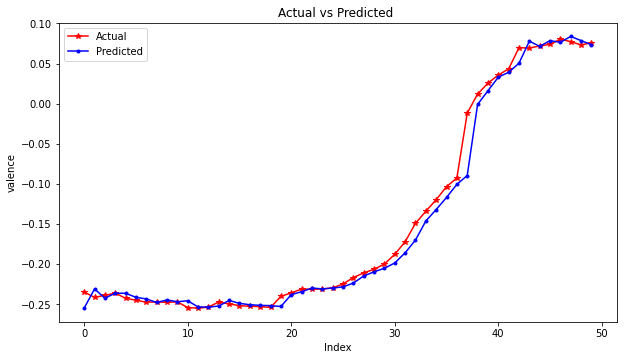

In [53]:
plt.figure(figsize=(10, 5.5))
plt.plot(test[0][10:], linestyle='-', marker='*', color='r')
plt.plot(preds[0:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted ')
plt.ylabel('valence')
plt.xlabel('Index')

In [55]:
'''
使用MLP进行时间序列预测
'''
#X_train and X_val are reshaped to 3D arrays
x_train, x_val = x_train.reshape((x_train.shape[0], x_train.shape[1], 1)), x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
print('Shape of arrays after reshaping:', x_train.shape, x_val.shape)

Shape of arrays after reshaping: (26750, 10, 1) (3000, 10, 1)


In [61]:
from keras.layers import Dense, Input, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

#Define input layer which has shape (None, 7) and of type float32. None indicates the number of instances
input_layer = Input(shape=(10,1), dtype='float32')
lstm_layer1 = LSTM(64, input_shape=(10,1), return_sequences=True)(input_layer)
lstm_layer2 = LSTM(32, input_shape=(10,64), return_sequences=False)(lstm_layer1)
dropout_layer = Dropout(0.2)(lstm_layer2)
#Finally the output layer gives prediction for the next day's air pressure.
output_layer = Dense(1, activation='linear')(dropout_layer)
lstm_model = Model(inputs=input_layer, outputs=output_layer)
lstm_model.compile(loss='mean_absolute_error', optimizer='adam')#SGD(lr=0.001, decay=1e-5))
lstm_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [62]:
save_weights_at = os.path.join('lstm_models', 'valence_LSTM_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
lstm_model.fit(x=x_train, y=y_train, batch_size=160, epochs=20,verbose=1, callbacks=[save_best], validation_data=(x_val, y_val),shuffle=True)

Epoch 1/20
168/168 [==============================] - 21s 51ms/step - loss: 0.0638 - val_loss: 0.0150
Epoch 2/20
168/168 [==============================] - 7s 42ms/step - loss: 0.0226 - val_loss: 0.0185
Epoch 3/20
168/168 [==============================] - 7s 42ms/step - loss: 0.0211 - val_loss: 0.0136
Epoch 4/20
168/168 [==============================] - 7s 42ms/step - loss: 0.0198 - val_loss: 0.0111
Epoch 5/20
168/168 [==============================] - 7s 42ms/step - loss: 0.0194 - val_loss: 0.0091
Epoch 6/20
168/168 [==============================] - 7s 42ms/step - loss: 0.0191 - val_loss: 0.0082
Epoch 7/20
168/168 [==============================] - 7s 42ms/step - loss: 0.0186 - val_loss: 0.0091
Epoch 8/20
168/168 [==============================] - 7s 42ms/step - loss: 0.0186 - val_loss: 0.0074
Epoch 9/20
168/168 [==============================] - 7s 43ms/step - loss: 0.0181 - val_loss: 0.0080
Epoch 10/20
168/168 [==============================] - 7s 42ms/step - loss: 0.0179 - val_l

In [63]:
from sklearn.metrics import mean_absolute_error
x_test, y_test = makeXy(test,nb_timesteps,stride)
best_model = load_model(os.path.join('lstm_models', 'valence_LSTM_weights.19-0.0055.hdf5'))
preds = best_model.predict(x_test)
preds = np.squeeze(preds)
mae = mean_absolute_error(y_test, preds)
print('MAE for the test set:', round(mae, 4))

MAE for the test set: 0.0063


Text(0.5, 0, 'Index')

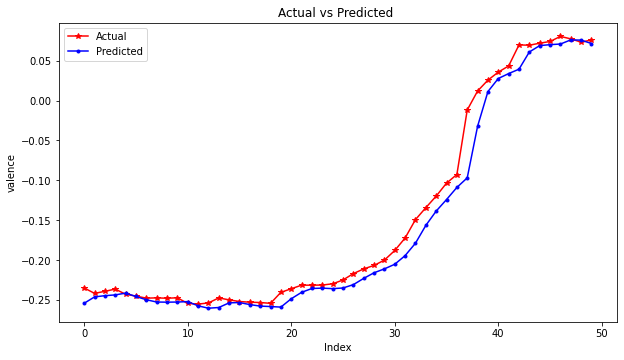

In [64]:
plt.figure(figsize=(10, 5.5))
plt.plot(test[0][10:], linestyle='-', marker='*', color='r')
plt.plot(preds[0:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted ')
plt.ylabel('valence')
plt.xlabel('Index')